# Predicting survivors on Titanic using tree-based method

## Part 1: Importing library

In [1]:
import sys 
import pandas as pd
import matplotlib 
import numpy as np
import scipy as sp 
import IPython
from IPython import display 
import sklearn 
import random
import time



In [15]:
#import model and visulizaing tools
from sklearn import tree, linear_model, ensemble, svm

from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#configurate matplotlib
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Part 2 : Import data


In [3]:
#import data
data1 = pd.read_csv("train.csv")
data_val = pd.read_csv("test.csv")

#show basic info
print(data1.info())
print(" -"*40)
data1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
429,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S
452,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
87,88,0,3,"Slocovski, Mr. Selman Francis",male,NaN,0,0,SOTON/OQ 392086,8.0500,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
414,415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S
165,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S


In [4]:
#show missing data
print(data1.isnull().sum())
print("- "*20)
print(data_val.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
- - - - - - - - - - - - - - - - - - - - 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
data_all = [data1, data_val]

#handle missing data
for dataset in data_all:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    
data1.drop(['PassengerId','Cabin', 'Ticket'], axis = 1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [6]:
#Feature Engineering for dataset
for dataset in data_all:    
    #create variable FamilySize
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    
    #create IsAlone
    dataset['IsAlone'] = 1 
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 

    #extract title from name
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #discretization of fare
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #discretization of age
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


#cleanup rare title names
print(data1['Title'].value_counts())
stat_min = 10 
title_names = (data1['Title'].value_counts() < stat_min) 
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("- "*20)


#show basic info 
data1.info()
data_val.info()
data1.sample(10)    


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Don               1
Mme               1
the Countess      1
Lady              1
Ms                1
Sir               1
Capt              1
Jonkheer          1
Name: Title, dtype: int64


C:\Users\Justin Tse\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Justin Tse\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
- - - - - - - - - - - - - - - - - - - - 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pa

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
825,0,3,"Flynn, Mr. John",male,28.0,0,0,6.9500,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
624,0,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,16.1000,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
438,0,1,"Fortune, Mr. Mark",male,64.0,1,4,263.0000,S,6,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"
62,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,83.4750,S,2,0,Mr,"(31.0, 512.329]","(32.0, 48.0]"
217,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,27.0000,S,2,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
34,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,82.1708,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
297,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,151.5500,S,4,0,Miss,"(31.0, 512.329]","(-0.08, 16.0]"
150,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,12.5250,S,1,1,Misc,"(7.91, 14.454]","(48.0, 64.0]"
410,0,3,"Sdycoff, Mr. Todor",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"


In [7]:
#code categorical data
label = LabelEncoder()
for dataset in data_all:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define target
Target = ['Survived']

#define x variables for original features
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] 
data1_xy =  Target + data1_x


#define x variables with all categorized
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin


#define x variables with only necessary discretization
data1_x_nec = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'Age', 'Fare']
data1_xy_nec = Target + data1_x_nec

data1_x_bin_temp = ['AgeBin_Code', 'FareBin_Code']
data1_x_nec_temp = ['Age', 'Fare']


In [8]:
data1[data1_x_bin]['AgeBin_Code'].value_counts()

1    525
2    186
0    100
3     69
4     11
Name: AgeBin_Code, dtype: int64

In [9]:
data1[data1_x_bin]['FareBin_Code'].value_counts()

1    224
0    223
2    222
3    222
Name: FareBin_Code, dtype: int64

In [10]:
data1[data1_x_nec].head(10)

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,Age,Fare
0,1,3,2,3,2,22.0,7.2500
1,0,1,0,4,2,38.0,71.2833
2,0,3,2,2,1,26.0,7.9250
3,0,1,2,4,2,35.0,53.1000
4,1,3,2,3,1,35.0,8.0500
5,1,3,1,3,1,28.0,8.4583
6,1,1,2,3,1,54.0,51.8625
7,1,3,2,0,5,2.0,21.0750
8,0,3,2,4,3,27.0,11.1333
9,0,2,0,4,2,14.0,30.0708


In [11]:
data1[data1_x_bin].head(10)

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
0,1,3,2,3,2,1,0
1,0,1,0,4,2,2,3
2,0,3,2,2,1,1,1
3,0,1,2,4,2,2,3
4,1,3,2,3,1,2,1
5,1,3,1,3,1,1,1
6,1,1,2,3,1,3,3
7,1,3,2,0,5,0,2
8,0,3,2,4,3,1,1
9,0,2,0,4,2,0,2


In [12]:
data1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,1,1,Misc,"(7.91, 14.454]","(16.0, 32.0]",1,2,1,1,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,1,1,Miss,"(14.454, 31.0]","(16.0, 32.0]",0,2,2,1,2
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S,4,0,Miss,"(14.454, 31.0]","(16.0, 32.0]",0,2,2,1,2
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]",1,0,3,1,2


In [18]:
data_val

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,1,1,Mr,"(-0.001, 7.896]","(30.4, 45.6]",1,1,5,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,2,0,Mrs,"(-0.001, 7.896]","(45.6, 60.8]",0,2,6,3,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,1,1,Mr,"(7.896, 14.454]","(60.8, 76.0]",1,1,5,4,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,5,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,3,0,Mrs,"(7.896, 14.454]","(15.2, 30.4]",0,2,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,NaN,...,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,5,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,1,1,Dona,"(31.472, 512.329]","(30.4, 45.6]",0,0,1,2,3
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,1,1,Mr,"(-0.001, 7.896]","(30.4, 45.6]",1,2,5,2,0
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,NaN,...,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,5,1,1


## Step 3.1: Model Data

In [13]:
def compare_MLA(variables):
    #Machine Learning Algorithm (MLA) 
    MLA = [
        #Ensemble Methods
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),


        #GLM
        linear_model.LogisticRegressionCV(),

        #Trees    
        tree.DecisionTreeClassifier(),
        
        #SVM
        svm.SVC(probability=True)
    ]


    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 99 ) # run model 10x with 60/30 split intentionally leaving out 10%

    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict = data1[Target]

    #index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())


        cv_results = model_selection.cross_validate(alg, data1[variables], data1[Target], cv  = cv_split, return_train_score=True)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   

        alg.fit(data1[variables], data1[Target])
        MLA_predict[MLA_name] = alg.predict(data1[variables])

        row_index+=1


    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    return MLA_compare

In [16]:
param_grid = [
    #SVM
    {
    'C': [0.1, 1, 10, 100, 1000],
    #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #'kernel': ['rbf']
    },
    
    #gradient boosting
    {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    },
    
    #random forest grid
    { 'n_estimators': [200, 500],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    },
    
    #logistic regression grid
    {
    'penalty': ['l1','l2'], 
     "Cs":[10]
    },
    
    #decision tree grid
    {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
    'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
    'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
    }
    

            
    
    
             
    ]

#Machine Learning Algorithm (MLA) 
MLA = [
    #SVM
    svm.SVC(probability=True),
    
    #ensemble tree-based
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),  

    #Trees    
    tree.DecisionTreeClassifier()
    

    ]

In [24]:
from sklearn.model_selection import GridSearchCV

def compare_MLA_gs(variables):

    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 100 ) # run model 10x with 60/30 split intentionally leaving out 10%

    
    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD']
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict = data1[Target]

    cv_results = []
    
    for i in range(0,len(MLA)):

        #set name and parameters
        MLA_name = MLA[i].__class__.__name__
        MLA_compare.loc[i, 'MLA Name'] = MLA_name
        
        grid_result = model_selection.GridSearchCV(MLA[i], param_grid[i], scoring = 'roc_auc', cv  = cv_split, return_train_score=True)
        grid_result.fit(data1[variables], data1[Target])
        
        MLA_compare.loc[i, 'MLA Parameters'] = str(grid_result.best_params_)
        MLA_compare.loc[i, 'MLA Train Accuracy Mean'] = grid_result.cv_results_['mean_train_score'][tune_model.best_index_]*100
        MLA_compare.loc[i, 'MLA Test Accuracy Mean'] = grid_result.cv_results_['mean_test_score'][tune_model.best_index_]*100
        MLA_compare.loc[i, 'MLA Test Accuracy 3*STD'] = grid_result.cv_results_['std_test_score'][tune_model.best_index_]*100*3

        alg.fit(data1[variables], data1[Target])
        #MLA_predict[MLA_name] = alg.predict(data_val[variables])
        cv_results.append(grid_result.cv_results_)
     


    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    return [MLA_compare, cv_results, MLA_predict]

In [25]:
[MLA_compare_bin, cv_results_bin, cv_predict_bin] = compare_MLA_gs(data1_x_bin)

C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Justin Tse\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

NameError: name 'tune_model' is not defined

In [366]:
MLA_compare_bin

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
4,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 4, 'random_...",89.632818,86.799306,4.844119
2,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",89.188418,86.599677,4.703276
1,GradientBoostingClassifier,"{'learning_rate': 0.15, 'loss': 'deviance', 'm...",91.315719,85.893921,6.720044
3,LogisticRegressionCV,"{'Cs': 10, 'penalty': 'l2'}",86.759518,85.665497,4.817815
0,SVC,{'C': 0.1},88.488571,84.223976,5.274345


In [368]:
[MLA_compare_nec, cv_results_nec] = compare_MLA_gs(data1_x_nec)

In [369]:
MLA_compare_nec

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
2,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",90.472955,86.410815,5.319646
3,LogisticRegressionCV,"{'Cs': 10, 'penalty': 'l2'}",86.063145,85.150016,5.011195
1,GradientBoostingClassifier,"{'learning_rate': 0.2, 'loss': 'deviance', 'ma...",92.511855,84.879984,7.425558
4,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 4, 'random_...",90.086761,84.670324,7.729409
0,SVC,{'C': 100},74.595554,74.335287,6.483699


In [390]:
compare_bin_original = compare_MLA(data1_x_bin)

In [391]:
compare_bin_original

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.83839,0.826493,0.059286,0.070706
0,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.872097,0.822388,0.033657,0.089094
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.899813,0.811194,0.034027,0.182235
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.899813,0.808955,0.044439,0.005686
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.80206,0.778731,0.052277,0.311267


In [392]:
compare_nec_original = compare_MLA(data1_x_nec)

In [393]:
compare_nec_original

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.922285,0.825373,0.05769,0.100948
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.98764,0.813433,0.025526,0.182288
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.809738,0.791418,0.057831,0.82209
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.987828,0.784701,0.040376,0.007579
4,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.677341,0.688433,0.069231,0.085074


In [371]:
[compare_bin_temp, cv_results_nec_temp] = compare_MLA_gs(data1_x_bin_temp)

In [379]:
compare_bin_temp

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
2,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 7, 'n_es...",80.566802,72.459786,5.431628
3,LogisticRegressionCV,"{'Cs': 10, 'penalty': 'l2'}",69.465787,71.018675,5.629895
1,GradientBoostingClassifier,"{'learning_rate': 0.15, 'loss': 'deviance', 'm...",80.035587,69.286844,5.627841
0,SVC,{'C': 0.1},68.279341,68.588901,4.215327
4,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 4, 'rand...",75.662698,68.269888,6.419702


In [386]:
[compare_nec_temp, cv_results_nec_temp] = compare_MLA_gs(data1_x_nec_temp)

In [387]:
compare_nec_temp

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
2,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 6, 'n_es...",80.598815,72.588722,5.19697
3,LogisticRegressionCV,"{'Cs': 10, 'penalty': 'l2'}",69.465787,71.018675,5.629895
1,GradientBoostingClassifier,"{'learning_rate': 0.15, 'loss': 'deviance', 'm...",80.035283,69.224634,5.341458
0,SVC,{'C': 0.1},68.279341,68.588901,4.215327
4,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 4, 'rand...",75.662698,68.269888,6.419702


In [384]:
compare_bin_temp_original = compare_MLA(data1_x_bin_temp)

In [385]:
compare_bin_temp_original

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.67397,0.678358,0.063283,0.005984
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.67397,0.676866,0.06176,0.169363
0,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.67397,0.671642,0.077231,0.07836
4,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.671536,0.669776,0.080449,0.073199
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.65412,0.668657,0.06024,0.16825


In [388]:
compare_nec_temp_original = compare_MLA(data1_x_nec_temp)

In [389]:
compare_nec_temp_original

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.827528,0.69291,0.074261,0.080813
4,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.673034,0.68097,0.072243,0.081964
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.661236,0.66903,0.065281,0.180957
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.959176,0.666045,0.050868,0.176177
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.959176,0.650373,0.073583,0.006582


In [440]:
cv_results_bin

[{'mean_fit_time': array([0.13191934, 0.1033381 , 0.10877278, 0.18989618, 0.28394144]),
  'std_fit_time': array([0.01864146, 0.01026697, 0.0083529 , 0.01867415, 0.04845095]),
  'mean_score_time': array([0.02802353, 0.02125435, 0.01893985, 0.02064121, 0.01834471]),
  'std_score_time': array([0.0037067 , 0.00244872, 0.00267799, 0.00484866, 0.00315612]),
  'param_C': masked_array(data=[0.1, 1, 10, 100, 1000],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}],
  'split0_test_score': array([0.85315331, 0.85211471, 0.84028619, 0.81397496, 0.83509319]),
  'split1_test_score': array([0.8504266 , 0.8439541 , 0.84889673, 0.82347749, 0.8397764 ]),
  'split2_test_score': array([0.8555355 , 0.81853815, 0.82970504, 0.81030399, 0.8098528 ]),
  'split3_test_score': array([0.83906078, 0.83871249, 0.8419632 , 0.82013699, 0.77451094]),
  'split4_test_score': array([0.8826610

## Step3.2: explore the best model

In [31]:
alg = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 6, random_state=  0)

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 99 ) # run model 10x with 60/30 split intentionally leaving out 10%
cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)

alg.fit(data1[data1_x_bin], data1[Target])
data_val['Survived'] = alg.predict(data_val[data1_x_bin])

#submit file
submit = data_val[['PassengerId','Survived']]
submit.to_csv("submit.csv", index=False)

In [30]:
len(MLA_predict)

418

In [27]:
import graphviz 
dot_data = tree.export_graphviz(alg, out_file=None,class_names=["Not survived","Survived"], feature_names=["Sex","Class","Embark","Title","Family Size","Age","Fare"]) 
graph = graphviz.Source(dot_data) 
graph.render("titanic") 

'titanic.pdf'

Feature: 0, Score: 0.53253
Feature: 1, Score: 0.18366
Feature: 2, Score: 0.02068
Feature: 3, Score: 0.06581
Feature: 4, Score: 0.14558
Feature: 5, Score: 0.02165
Feature: 6, Score: 0.03010


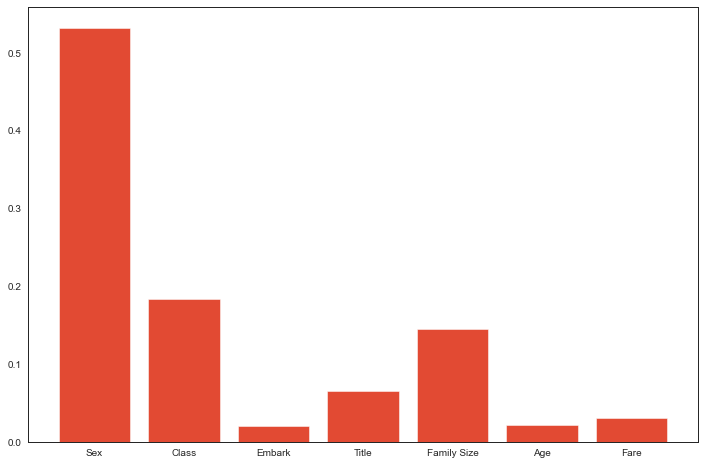

In [24]:
# get importance
importance = alg.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar(["Sex","Class","Embark","Title","Family Size","Age","Fare"], importance)
plt.show()

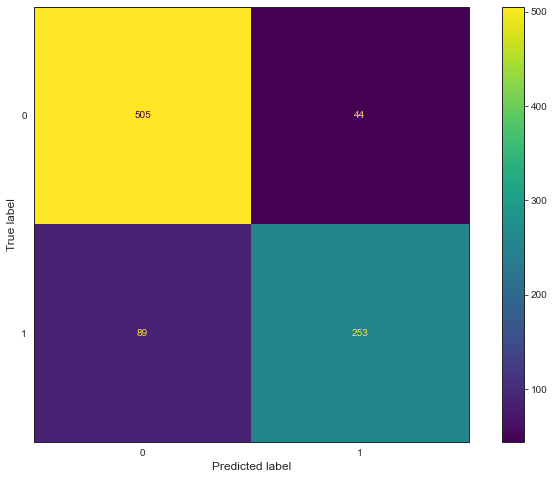

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


plot_confusion_matrix(alg, data1[data1_x_bin], data1[Target])  
plt.show()

## Step 4: Visualizing decision boundary 

In [96]:
from sklearn.datasets import make_classification
X_ex, y_ex = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=1)

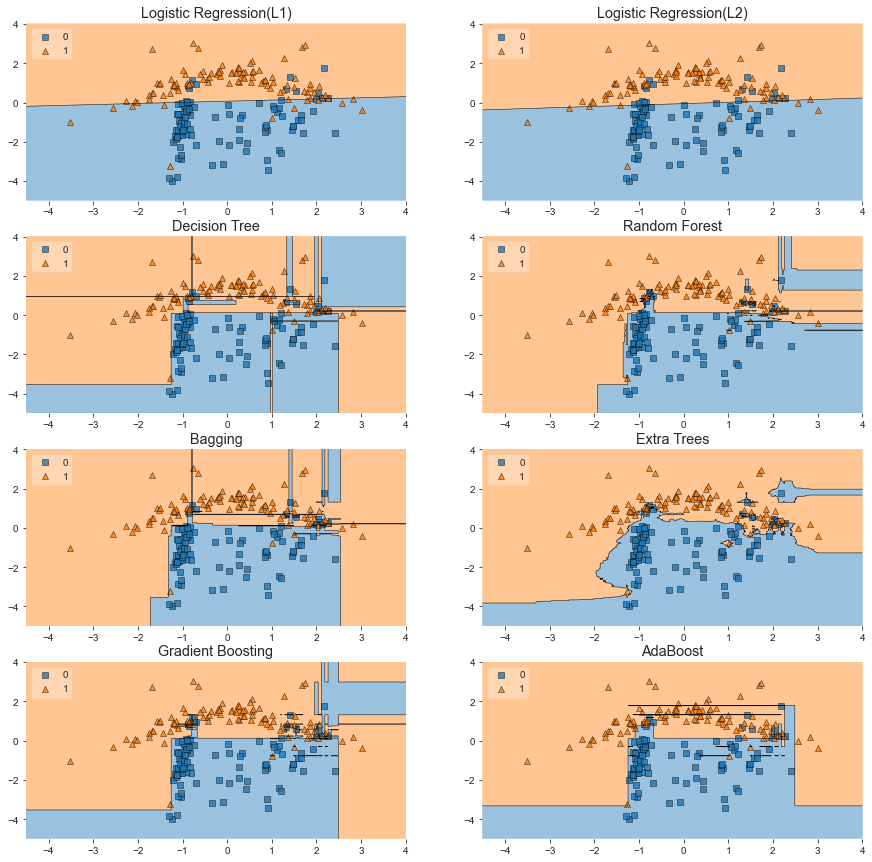

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
 
 
 
# Initializing Classifiers
clf1 = LogisticRegression()
clf2 = linear_model.RidgeClassifierCV()
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()
clf5 = ensemble.BaggingClassifier()
clf6 = ensemble.ExtraTreesClassifier()
clf7 = ensemble.GradientBoostingClassifier()
clf8 = ensemble.AdaBoostClassifier()
 
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
%matplotlib inline  
 
gs = gridspec.GridSpec(4, 2)
 
fig = plt.figure(figsize=(15,15))
 
labels = ['Logistic Regression(L1)', 'Logistic Regression(L2)', 'Decision Tree', 'Random Forest', 'Bagging', 'Extra Trees', 'Gradient Boosting','AdaBoost']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6,clf7,clf8],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1),(3,0),(3,1)]):
 
    clf.fit(X_ex, y_ex)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_ex, y=y_ex, clf=clf, legend=2)
    plt.title(lab)
 
plt.show()

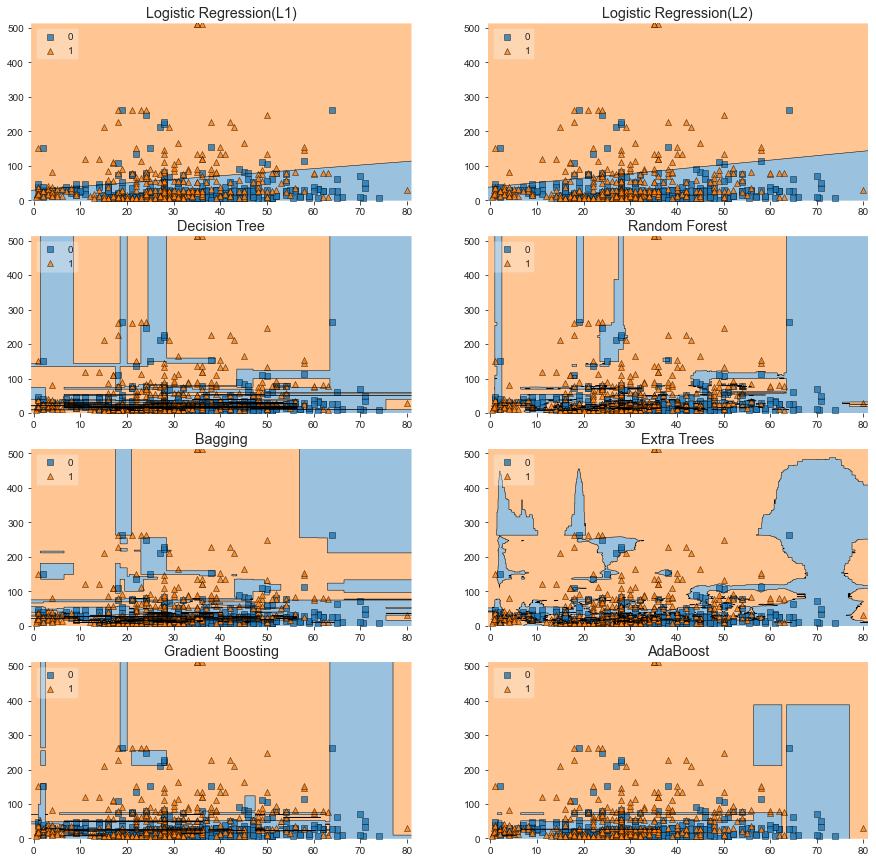

In [438]:
#convert from pd dataframe to numpy array
y_temp = []
for i in range(0,len(y)):

    y_temp.append(y[i][0])

y_np = np.array(y_temp)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
 
 
 
# Initializing Classifiers
clf1 = LogisticRegression()
clf2 = linear_model.RidgeClassifierCV()
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()
clf5 = ensemble.BaggingClassifier()
clf6 = ensemble.ExtraTreesClassifier()
clf7 = ensemble.GradientBoostingClassifier()
clf8 = ensemble.AdaBoostClassifier()
 
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
%matplotlib inline  
 
gs = gridspec.GridSpec(4, 2)
 
fig = plt.figure(figsize=(15,15))
 
labels = ['Logistic Regression(L1)', 'Logistic Regression(L2)', 'Decision Tree', 'Random Forest', 'Bagging', 'Extra Trees', 'Gradient Boosting','AdaBoost']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6,clf7,clf8],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1),(3,0),(3,1)]):
 
    clf.fit(data1[data1_x_nec_temp], data1[Target])
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=data1[data1_x_nec_temp].to_numpy (), y=y_np, clf=clf, legend=2)
    plt.title(lab)
 
plt.show()

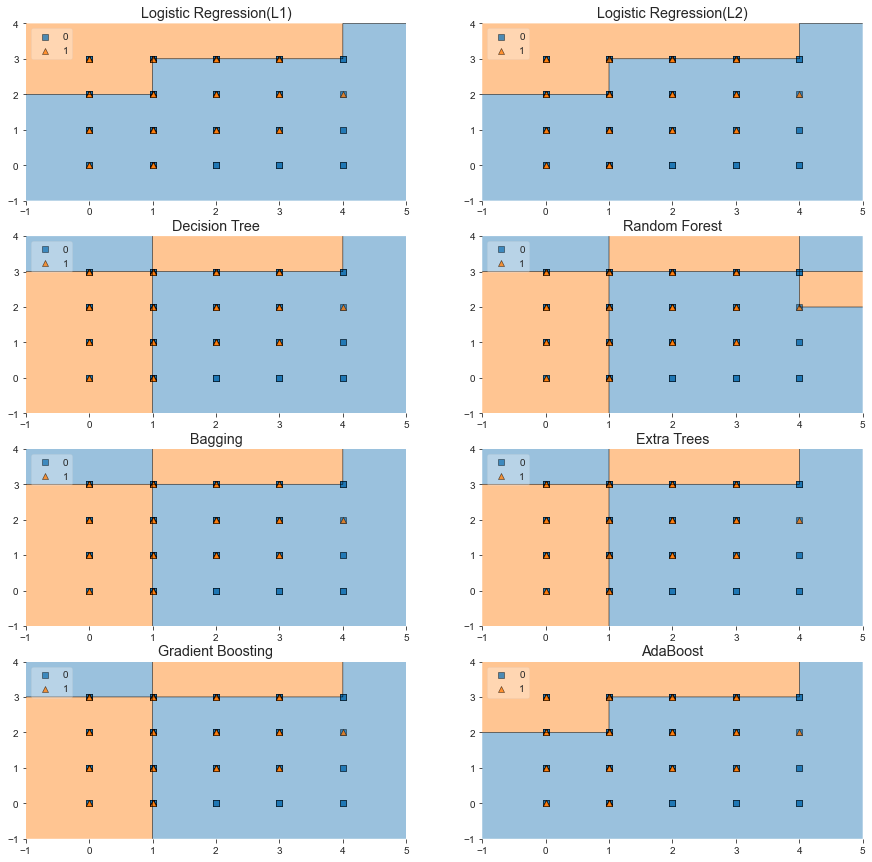

In [439]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
 
 
 
# Initializing Classifiers
clf1 = LogisticRegression()
clf2 = linear_model.RidgeClassifierCV()
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()
clf5 = ensemble.BaggingClassifier()
clf6 = ensemble.ExtraTreesClassifier()
clf7 = ensemble.GradientBoostingClassifier()
clf8 = ensemble.AdaBoostClassifier()
 
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
%matplotlib inline  
 
gs = gridspec.GridSpec(4, 2)
 
fig = plt.figure(figsize=(15,15))
 
labels = ['Logistic Regression(L1)', 'Logistic Regression(L2)', 'Decision Tree', 'Random Forest', 'Bagging', 'Extra Trees', 'Gradient Boosting','AdaBoost']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6,clf7,clf8],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1),(3,0),(3,1)]):
 
    clf.fit(data1[data1_x_bin_temp], data1[Target])
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=data1[data1_x_bin_temp].to_numpy (), y=y_np, clf=clf, legend=2)
    plt.title(lab)
 
plt.show()